In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import r2_score
import math
from sklearn.metrics import mean_squared_error
from matplotlib.dates import DateFormatter, AutoDateLocator
import datetime as dt
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import MaxPool1D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import AveragePooling1D
from keras.layers import GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow import math as ops

In [3]:
Smog_data = pd.read_csv('Lahore_Smog.csv')
Smog_data['date']=pd.to_datetime(Smog_data['date'],format='%d/%m/%Y')
Smog_data.set_index('date',inplace=True)
Smog_data=Smog_data.asfreq('D')

In [3]:
test_data_smog = pd.read_csv('smog_testing_data.csv')
test_data_smog['date']=pd.to_datetime(test_data_smog['date'],format='%d/%m/%Y')
test_data_smog.set_index('date',inplace=True)
test_data_smog=test_data_smog.asfreq('D')

In [4]:
Smog_data.shape

(7243, 12)

In [5]:
Smog_data.tail()

,us,vs,rh,temp,o3,co,no,no2,so2,pm1,pm10,pm2.5
date,,,,,,,,,,,,
2022-12-27,1.463813,0.111734,100.808180,278.86743,92.006117,32.464496,0.003292,0.150420,0.190501,267.0,440.0,311.0
2022-12-28,1.735937,0.198573,89.261185,280.10492,89.318680,23.651397,0.003566,0.110948,0.146610,265.0,437.0,308.0
2022-12-29,2.176536,0.591277,86.507675,283.36365,88.441643,26.929997,0.030785,0.122683,0.188977,368.0,608.0,428.0
2022-12-30,0.045942,-1.542575,95.620500,282.77450,89.296764,27.051308,0.009235,0.110186,0.120092,289.0,479.0,338.0
2022-12-31,1.851134,-0.282247,90.744320,280.74540,88.611844,17.522641,0.001905,0.117196,0.102718,209.0,347.0,245.0


In [6]:
Smog_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7243 entries, 2003-01-02 to 2022-10-31
Freq: D
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   us      7243 non-null   float64
 1   vs      7243 non-null   float64
 2   rh      7243 non-null   float64
 3   temp    7243 non-null   float64
 4   o3      7243 non-null   float64
 5   co      7243 non-null   float64
 6   no      7243 non-null   float64
 7   no2     7243 non-null   float64
 8   so2     7243 non-null   float64
 9   pm1     7243 non-null   float64
 10  pm10    7243 non-null   float64
 11  pm2.5   7243 non-null   float64
dtypes: float64(12)
memory usage: 735.6 KB


In [7]:
Smog_data.describe()

,us,vs,rh,temp,o3,co,no,no2,so2,pm1,pm10,pm2.5
count,7243.000000,7243.000000,7243.000000,7243.000000,7243.000000,7243.000000,7243.000000,7243.000000,7243.000000,7243.000000,7243.000000,7243.000000
mean,-0.251457,0.028517,76.265008,293.125345,94.968986,19.380509,0.013331,0.109036,0.127271,200.030595,338.481872,241.787119
std,1.562065,1.100013,17.149216,7.581248,6.260292,3.994990,0.015012,0.033080,0.045711,100.657738,160.318159,111.820261
min,-6.497691,-4.537613,17.343384,275.127000,74.415626,12.363140,0.000035,0.041605,0.015545,16.700000,27.900000,19.800000
25%,-1.444007,-0.712679,67.571159,286.286850,91.369348,16.727437,0.001238,0.086106,0.093727,114.500000,208.000000,153.000000
50%,-0.364739,0.129987,80.598860,294.561680,94.333507,18.524708,0.007940,0.103175,0.120397,185.000000,313.000000,225.000000
75%,1.140049,0.829520,88.774115,299.965550,97.947183,20.950884,0.020879,0.125883,0.153925,276.000000,458.000000,324.000000
max,4.276106,4.940400,103.836060,306.676100,130.701004,49.411794,0.093879,0.339854,0.406910,557.000000,913.000000,648.000000


In [8]:
labels={"us":"U-Component of Wind Speed (m/s)","vs":"V-Component of Wind Speed (m/s)",'o3':"Ozone (ug/m3)",'co':"Carbon DiOxide (ug/m3)","no":"Nitrogen Oxide (ug/m3)","no2":'Nitrogen DiOxide (ug/m3)','pm1':'Particulate Matter 1 (ug/m3)',"so2":'Sulpher DiOxide (ug/m3)',"pm10":"Particulate Matter 10 (ug/m3)","pm2.5":"Particulate Matter 2.5 (ug/m3)","temp":'Temperature (K)',"rh":"Relative Humidity (%)","p":"Surface Pressure (Pa)"}

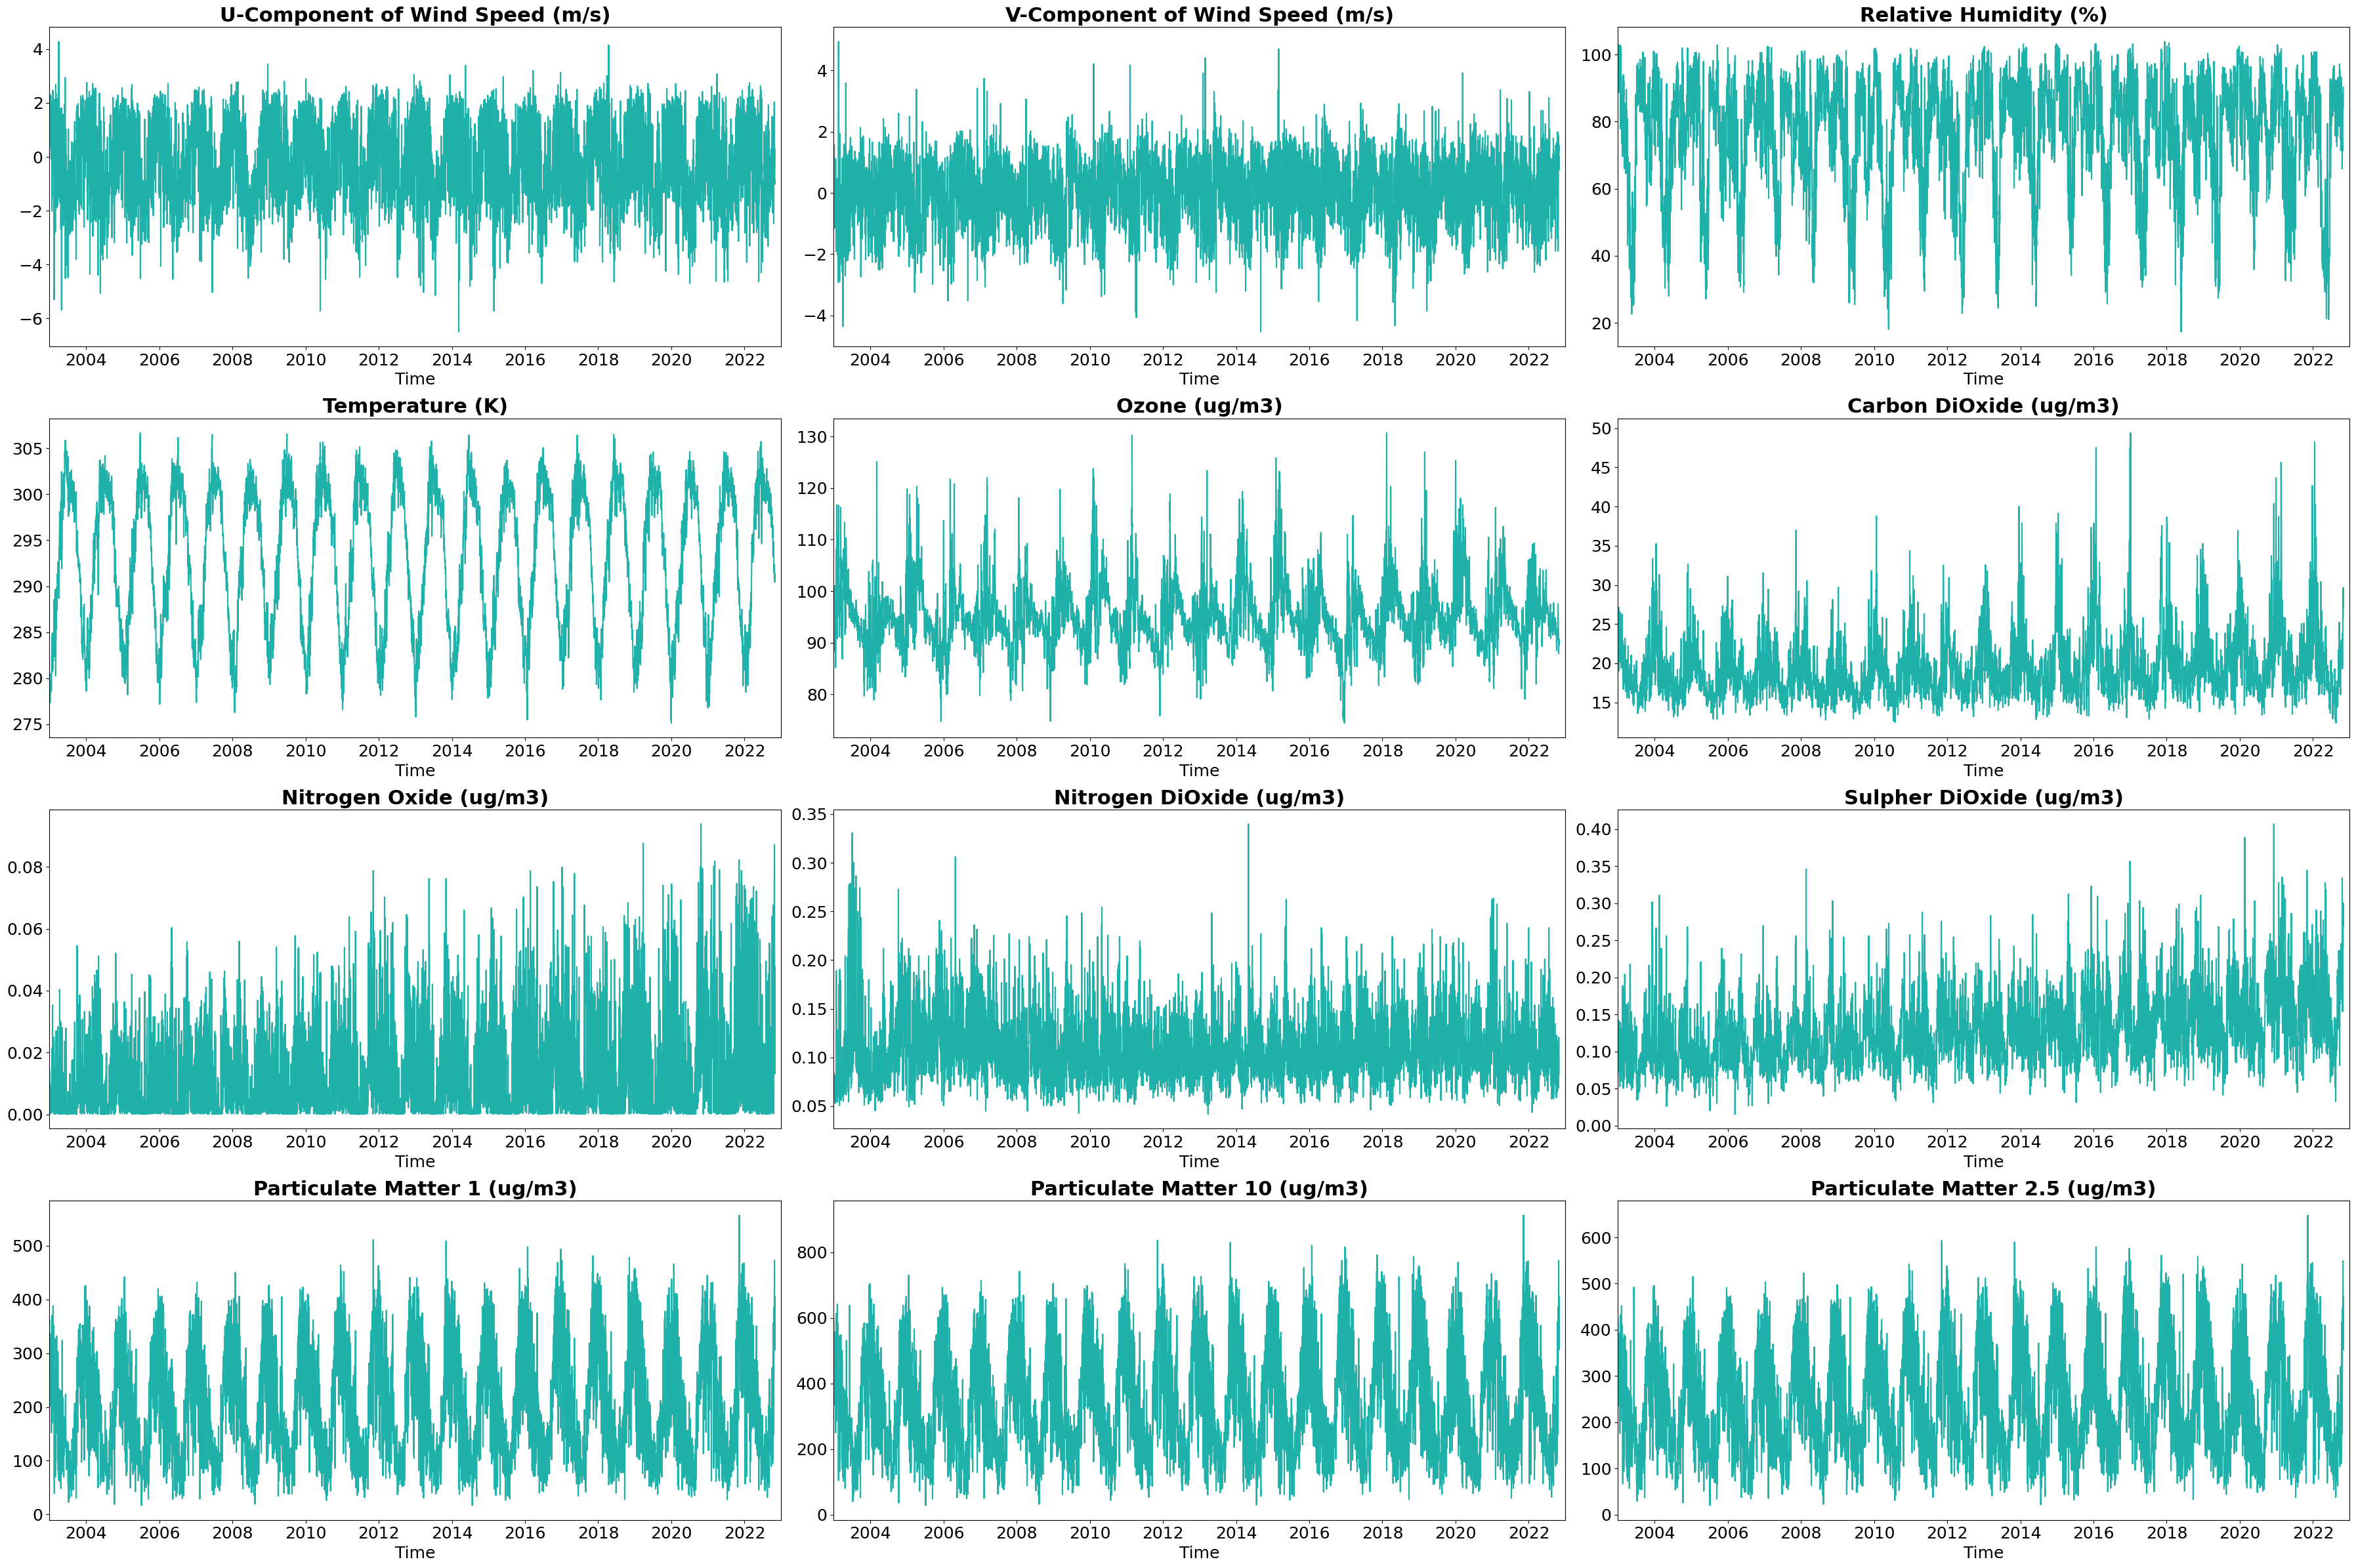

In [9]:
num_cols = len(Smog_data.columns)
num_rows = -(-num_cols // 3)  # Ceil division to ensure all columns are covered

fig, axs = plt.subplots(num_rows, 3, figsize=(36, 24))  # 3 columns

# Flatten the axs array if num_rows > 1 for easier iteration
if num_rows > 1:
    axs = axs.flatten()

for i, column in enumerate(Smog_data.columns):
    axs[i].set_xlim([dt.datetime(2003, 1, 1), dt.datetime(2022, 12, 31)])
    axs[i].set_title(labels[column], fontsize=22, fontweight='bold')  # Adjust title text
    axs[i].set_xlabel('Time', fontsize=18)  # Adjust x-axis label
    axs[i].tick_params(axis='both', which='major', labelsize=18)  # Adjust tick labels
    axs[i].plot(Smog_data.index, Smog_data[column], color='lightseagreen')

# Hide empty subplots if the number of subplots is not a perfect square
if num_cols % 3 != 0:
    for i in range(num_cols, num_rows * 3):
        axs[i].axis('off')

plt.tight_layout()
plt.show()


In [10]:
train_data = Smog_data.iloc[:,10:11].values
train_data

array([[597.],
       [535.],
       [419.],
       ...,
       [544.],
       [503.],
       [666.]])

In [49]:
feature_scalling =  MinMaxScaler(feature_range=(0,1))
training_data = feature_scalling.fit_transform(train_data)

In [50]:
x_train = []
y_train = []
for i in range(60,7243):
  x_train.append(training_data[i-60:i,0])
  y_train.append(training_data[i,0])

In [51]:
x_train = np.array(x_train)
x_train.shape

(7183, 60)

In [52]:
y_train = np.array(y_train)
y_train.shape

(7183,)

In [53]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_train.shape

(7183, 60, 1)

In [54]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

model = Sequential()

model.add(LSTM(units=100, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=80, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=60, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=40, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 100)           40800     
                                                                 
 dropout_4 (Dropout)         (None, 60, 100)           0         
                                                                 
 lstm_5 (LSTM)               (None, 60, 80)            57920     
                                                                 
 dropout_5 (Dropout)         (None, 60, 80)            0         
                                                                 
 lstm_6 (LSTM)               (None, 60, 60)            33840     
                                                                 
 dropout_6 (Dropout)         (None, 60, 60)            0         
                                                                 
 lstm_7 (LSTM)               (None, 40)               

In [55]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * ops.exp(-0.01)

In [56]:
callback_lr = LearningRateScheduler(scheduler)

In [57]:
checkpoint = ModelCheckpoint("best_model.h5", monitor='loss', save_best_only=True, mode='min', verbose=1)

In [58]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [21]:
callback_es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

In [59]:
 epochs_hist = model.fit(x_train,y_train,epochs = 100,batch_size = 32, callbacks=[callback_lr,checkpoint,callback_es])

Epoch 1/100
225/225 [==============================] - ETA: 0s - loss: 0.0255
Epoch 1: loss improved from inf to 0.02554, saving model to best_model.h5
225/225 [==============================] - 20s 68ms/step - loss: 0.0255 - lr: 0.0010
Epoch 2/100
  2/225 [..............................] - ETA: 15s - loss: 0.0213

C:\Users\PMLS\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


224/225 [============================>.] - ETA: 0s - loss: 0.0193
Epoch 2: loss improved from 0.02554 to 0.01929, saving model to best_model.h5
225/225 [==============================] - 15s 68ms/step - loss: 0.0193 - lr: 0.0010
Epoch 3/100
225/225 [==============================] - ETA: 0s - loss: 0.0183
Epoch 3: loss improved from 0.01929 to 0.01833, saving model to best_model.h5
225/225 [==============================] - 16s 69ms/step - loss: 0.0183 - lr: 0.0010
Epoch 4/100
225/225 [==============================] - ETA: 0s - loss: 0.0177
Epoch 4: loss improved from 0.01833 to 0.01766, saving model to best_model.h5
225/225 [==============================] - 17s 74ms/step - loss: 0.0177 - lr: 0.0010
Epoch 5/100
225/225 [==============================] - ETA: 0s - loss: 0.0176
Epoch 5: loss improved from 0.01766 to 0.01764, saving model to best_model.h5
225/225 [==============================] - 16s 73ms/step - loss: 0.0176 - lr: 0.0010
Epoch 6/100
225/225 [===========================

In [60]:
testing_data = test_data_smog.iloc[:, 10:11].values

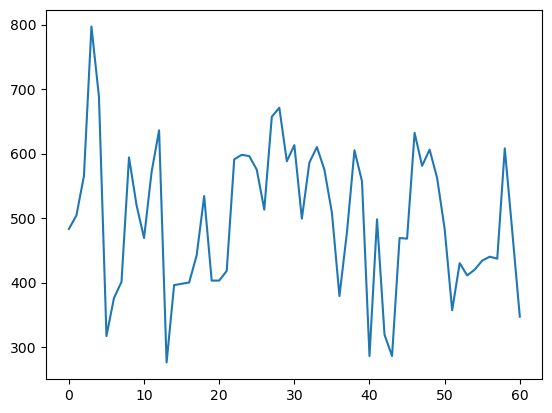

In [61]:
plt.plot(testing_data)

In [63]:
total_dataset = pd.concat((Smog_data['pm10'],test_data_smog['pm10']),axis = 0)
total_dataset

date
2003-01-02    597.0
2003-01-03    535.0
2003-01-04    419.0
2003-01-05    436.0
2003-01-06    462.0
              ...  
2022-12-27    440.0
2022-12-28    437.0
2022-12-29    608.0
2022-12-30    479.0
2022-12-31    347.0
Freq: D, Name: pm10, Length: 7304, dtype: float64

In [64]:
inputs = total_dataset[len(total_dataset) - len(test_data_smog) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = feature_scalling.transform(inputs)

In [65]:
inputs

array([[0.2012202 ],
       [0.25658118],
       [0.13456107],
       [0.06778895],
       [0.36843295],
       [0.44413061],
       [0.35713479],
       [0.2656197 ],
       [0.22607615],
       [0.23511468],
       [0.24302339],
       [0.21703762],
       [0.24867247],
       [0.28482657],
       [0.21590781],
       [0.18314315],
       [0.27465823],
       [0.34470681],
       [0.27578805],
       [0.22042707],
       [0.29160547],
       [0.2723986 ],
       [0.2723986 ],
       [0.14021015],
       [0.13569088],
       [0.30177381],
       [0.27804768],
       [0.36730313],
       [0.39667834],
       [0.29160547],
       [0.30742289],
       [0.4791549 ],
       [0.42831318],
       [0.40571687],
       [0.23737431],
       [0.30290363],
       [0.33114902],
       [0.14472941],
       [0.16619591],
       [0.17862388],
       [0.36843295],
       [0.48819342],
       [0.61021354],
       [0.63393967],
       [0.50401085],
       [0.53225624],
       [0.40458705],
       [0.345

In [66]:
X_test = []
for i in range(60, 121):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [67]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = feature_scalling.inverse_transform(predicted_stock_price)

2/2 [==============================] - 1s 27ms/step


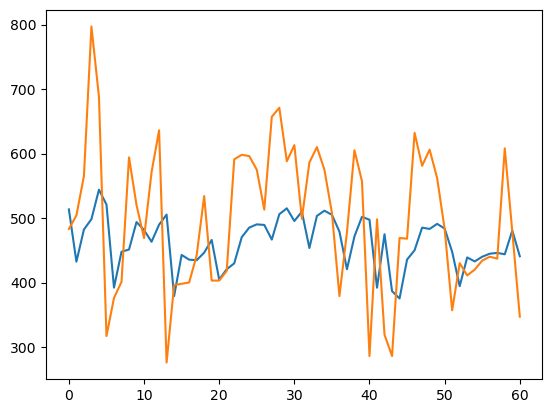

In [68]:
plt.plot(predicted_stock_price)
plt.plot(testing_data)

In [69]:
mse_vs = mean_squared_error(testing_data, predicted_values)

In [2]:
mse_vs

0.0674275089

In [7]:
rmse = math.sqrt(mse_vs)
rmse

0.25966807447200746

In [35]:
future_timestamps = 365 * 7
x_future = x_train[-60:] 
predictions = []
for i in range(future_timestamps):
    pred = model.predict(x_future)[0, 0]
    predictions.append(pred)
    x_future = np.roll(x_future, -1, axis=1) 
    x_future[0, -1, 0] = pred 
predictions = np.array(predictions).reshape(-1, 1)
predictions = feature_scalling.inverse_transform(predictions)




2/2 [==============================] - 0s 15ms/step


In [36]:
csv_file_path = "output_p1.csv"

In [ ]:
output_data  = pd.read_csv("output_polutants.csv")

C:\Users\PMLS\AppData\Local\Temp\ipykernel_9528\4045148068.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('viridis')


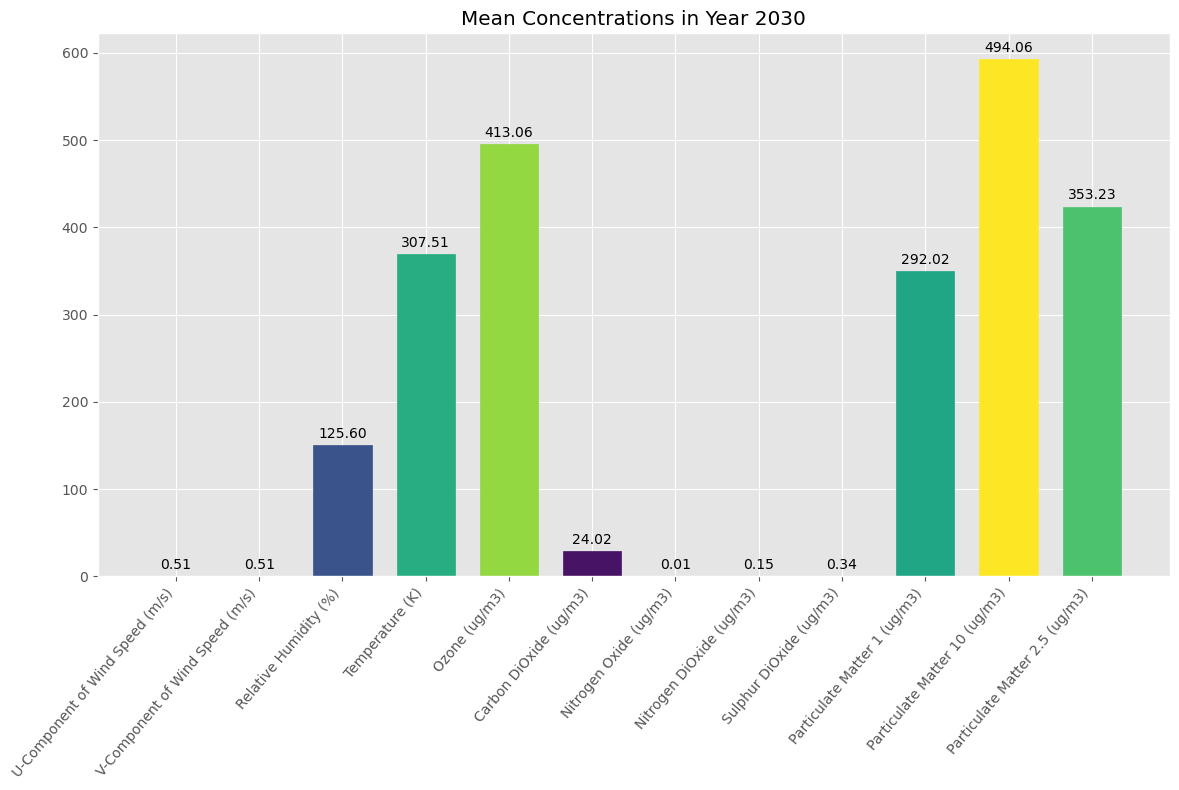

In [8]:
mean_values_list = []
for columns in output_data:
    mean_value = output_data[columns].mean()
    mean_value.append(mean_values_list)
plt.style.use('ggplot')
listed = [
    'U-Component of Wind Speed (m/s)',
    'V-Component of Wind Speed (m/s)',
    'Relative Humidity (%)',
    'Temperature (K)',
    'Ozone (ug/m3)',
    'Carbon DiOxide (ug/m3)',
    'Nitrogen Oxide (ug/m3)',
    'Nitrogen DiOxide (ug/m3)',
    'Sulphur DiOxide (ug/m3)',
    'Particulate Matter 1 (ug/m3)',
    'Particulate Matter 10 (ug/m3)',
    'Particulate Matter 2.5 (ug/m3)'
]
norm = plt.Normalize(min(mean_values_list), max(mean_values_values_list))
cmap = mpl.cm.get_cmap('viridis')
colors = cmap(norm(mean_values_list))
fig, ax = plt.subplots(figsize=(12, 8))
bar_height = 1.2 * np.array(values_list)
bars = ax.bar(np.arange(len(mean_values_list)), bar_height, width=0.7, color=colors)\
for bar, color, value in zip(bars, colors, mean_values_list):
    bar.set_color(color)
    height = bar.get_height()
    ax.annotate(f'{value:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')
plt.xticks(np.arange(len(mean_values_list)), listed, rotation=50, ha='right')
plt.title('Mean Concentrations in Year 2030')
plt.tight_layout()
plt.show()


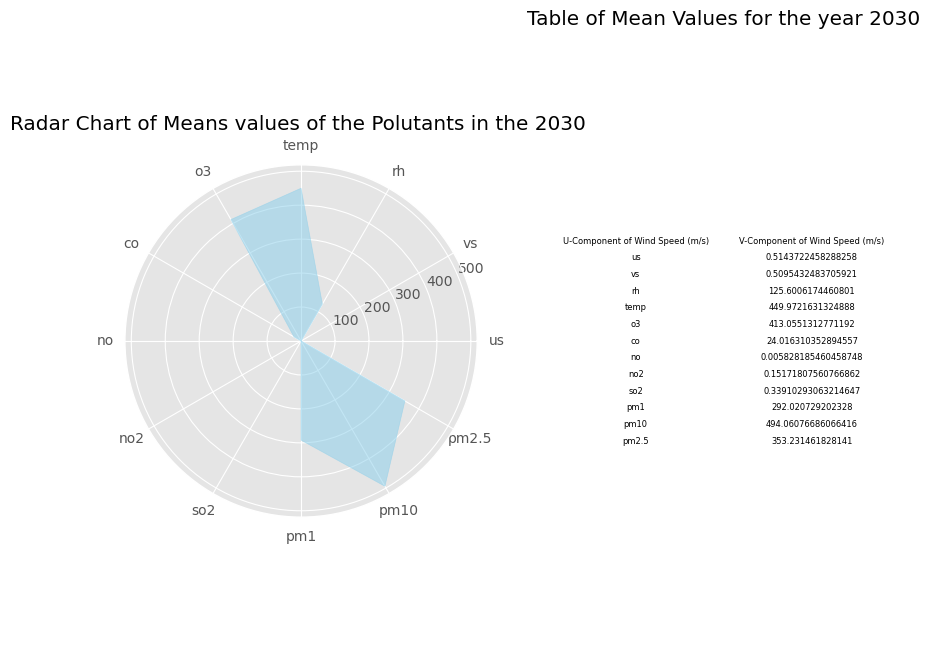

In [13]:
mean_values_list = []
for columns in output_data:
    mean_value = output_data[columns].mean()
    mean_value.append(mean_values_list)
listed = [
    
    'U-Component of Wind Speed (m/s)',
    'V-Component of Wind Speed (m/s)',
    'Relative Humidity (%)',
    'Temperature (K)',
    'Ozone (ug/m3)',
    'Carbon DiOxide (ug/m3)',
    'Nitrogen Oxide (ug/m3)',
    'Nitrogen DiOxide (ug/m3)',
    'Sulphur DiOxide (ug/m3)',
    'Particulate Matter 1 (ug/m3)',
    'Particulate Matter 10 (ug/m3)',
    'Particulate Matter 2.5 (ug/m3)'
]
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(121, polar=True)
theta = np.linspace(0, 2 * np.pi, len(mean_values), endpoint=False)
ax1.fill(theta, values, color='skyblue', alpha=0.5)
ax1.set_xticks(theta)
ax1.set_xticklabels(mean_values_list.index)
ax1.set_title('Radar Chart of Means values of the Polutants in the 2030 ')
ax2 = fig.add_subplot(122)
df = pd.DataFrame({'Column': mean_values_list.index, 'Mean Value': mean_values_list})
table = ax2.table(cellText=df.values, colLabels=listed, loc='center', cellLoc='center', edges='open')
ax2.axis('off')
ax2.set_title('Table of Mean Values for the year 2030')
plt.show()

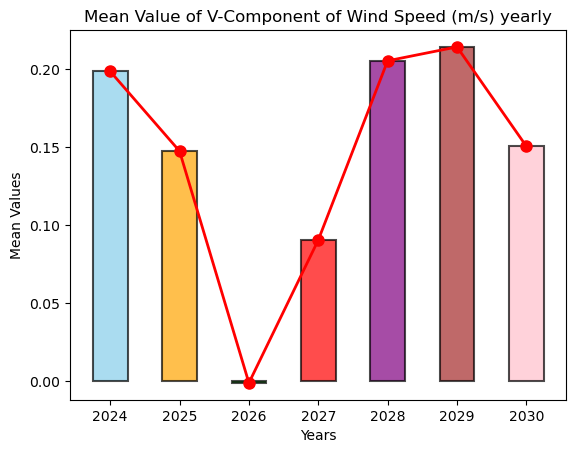

In [58]:
output_data_po = output_data.iloc[:,1].values
num_entries = len(data)
part_size = num_entries 
split_data = [data[i * part_size:(i + 1) * part_size] for i in range(7)]
means = [np.mean(part) for part in split_data]
bar_width = 0.5  
bar_colors = ['skyblue', 'orange', 'green', 'red', 'purple', 'brown', 'pink']  # Specify colors for each bar
plt.bar(range(1, 8), means, color=bar_colors, alpha=0.7, width=bar_width, edgecolor='black', linewidth=1.5)
plt.plot(range(1, 8), means, color='red', marker='o', linestyle='-', linewidth=2, markersize=8)
plt.xlabel('Years')
plt.xticks(range(1, 8), ['2024', '2025', '2026', '2027', '2028', '2029', '2030'])
plt.ylabel('Mean Values')
plt.title('Mean Value of V-Component of Wind Speed (m/s) yearly')
plt.show()

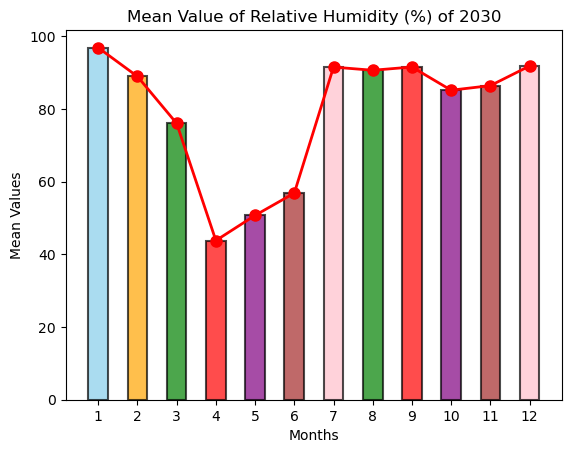

In [63]:
output_data_po = output_data.iloc[:,1].values
output_data_po = output_data_po[-365:]
num_entries = len(output_data_po)
part_size = num_entries
split_data = [data[i * part_size:(i + 1) * part_size] for i in range(12)]
means = [np.mean(part) for part in split_data]
bar_width = 0.5
bar_colors = ['skyblue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'green', 'red', 'purple', 'brown', 'pink']
plt.bar(range(1, 13), means, color=bar_colors, alpha=0.7, width=bar_width, edgecolor='black', linewidth=1.5)
plt.plot(range(1, 13), means, color='red', marker='o', linestyle='-', linewidth=2, markersize=8)
plt.xlabel('Months')
plt.xticks(range(1, 13), ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
plt.ylabel('Mean Values')
plt.title('Mean Value of Relative Humidity (%) of 2030')
plt.show()

In [31]:
AQI = output_data.iloc[:, 11].values
AQI_data = AQI[-365:]
AQI_values = []
ranges = [(0.0, 12.0, 0, 12, 50, 0),
          (12.1, 35.4, 12.1, 35.4, 100, 51),
          (35.5, 55.4, 35.5, 55.4, 150, 101),
          (55.5, 150.4, 55.5, 150.4, 200, 151),
          (150.5, 250.4, 150.5, 250.4, 300, 201),
          (250.5, 350.4, 250.5, 350.4, 400, 301),
          (350.5, 500.4, 350.5, 500.4, 500, 401)]
for i in AQI_data:
    for r in ranges:
        if r[0] <= i <= r[1]:
            AQI = ((r[4] - r[5]) / (r[3] - r[2])) * (i - r[2]) + r[5]
            AQI_values.append(AQI)
            break
AQI_array = np.array(AQI_values)
print(AQI_array)

[373.83783784 373.83783784 406.61374249 226.27027027 237.17117117
 177.53951528 435.01267512 391.67567568 417.84122748 444.25883923
 438.97531688 476.62041361 414.53902602 333.20720721 452.84456304
 417.84122748 477.9412942  494.45230153 394.64864865 187.60800843
 499.73582388 357.98198198 451.52368245 372.84684685 355.00900901
 469.35557038 412.55770514 311.40540541 446.24016011 491.15010007
 443.59839893 414.53902602 481.90393596 334.1981982  404.63242161
 478.60173449 481.90393596 482.56437625 493.13142095 497.754503
 424.44563042 442.93795864 295.63963964 366.9009009  338.16216216
 278.79279279 411.89726484 422.46430954 182.54794521 335.18918919
 284.73873874 292.66666667 481.90393596 210.41441441 317.35135135
 279.78378378 386.72072072 417.18078719 275.81981982 439.63575717
 332.21621622 411.89726484 399.6036036  448.22148099 472.65777185
 315.36936937 280.77477477 395.63963964 316.36036036 410.57638426
 394.64864865 395.63963964 422.46430954 388.7027027  382.75675676
 314.3783783

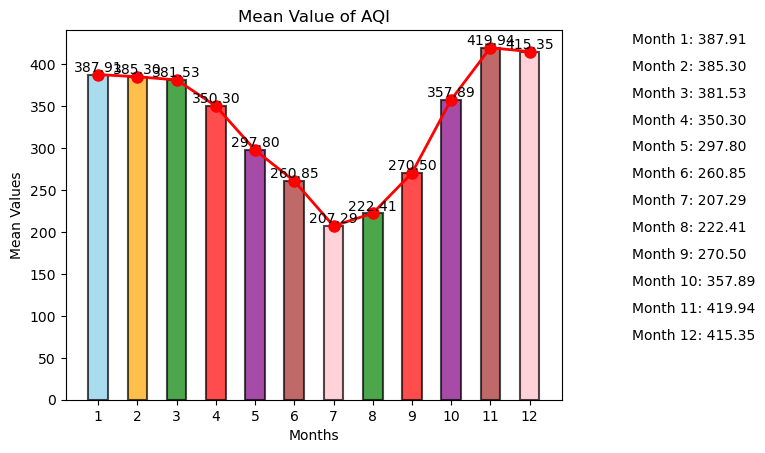

In [37]:
AQI = output_data.iloc[:, 11].values
AQI_data = AQI[-365:]
AQI_values = []
ranges = [(0.0, 12.0, 0, 12, 50, 0),
          (12.1, 35.4, 12.1, 35.4, 100, 51),
          (35.5, 55.4, 35.5, 55.4, 150, 101),
          (55.5, 150.4, 55.5, 150.4, 200, 151),
          (150.5, 250.4, 150.5, 250.4, 300, 201),
          (250.5, 350.4, 250.5, 350.4, 400, 301),
          (350.5, 500.4, 350.5, 500.4, 500, 401)]
for i in AQI_data:
    for r in ranges:
        if r[0] <= i <= r[1]:
            AQI = ((r[4] - r[5]) / (r[3] - r[2])) * (i - r[2]) + r[5]
            AQI_values.append(AQI)
            break  
AQI_array = np.array(AQI_values)
num_parts = 12
part_size = len(AQI_array) // num_parts
means = [np.mean(AQI_array[i * part_size:(i + 1) * part_size]) for i in range(num_parts)]
bar_colors = ['skyblue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'green', 'red', 'purple', 'brown', 'pink']
bar_width = 0.5  
fig, ax1 = plt.subplots()
bars = ax1.bar(range(1, num_parts + 1), means, color=bar_colors, alpha=0.7, width=bar_width, edgecolor='black', linewidth=1.5)
line = ax1.plot(range(1, num_parts + 1), means, color='red', marker='o', linestyle='-', linewidth=2, markersize=8)
ax1.set_xlabel('Months')
ax1.set_xticks(range(1, num_parts + 1))
ax1.set_xticklabels(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
ax1.set_ylabel('Mean Values')
for bar, value in zip(bars, means):
    ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.2f}', ha='center', va='bottom')
ax2 = fig.add_axes([1.0, 0.1, 0.1, 0.8])  
ax2.axis('off')
for i, mean_value in enumerate(means):
    ax2.text(0.1, 0.95 - i * 0.07, f'Month {i+1}: {mean_value:.2f}', transform=ax2.transAxes, fontsize=10, ha='left', va='center')
plt.show()
